<a href="https://colab.research.google.com/github/taras-musakovskyi/colab-jupyter-fish-models/blob/main/CycleGAN_ImageSpace_Dry_to_Wet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌊 CycleGAN Training: Dry ↔ Underwater Apartment (Image Space)

**Architecture:** CycleGAN in RGB Image Space (512×512×3)

**Key Configuration:**
- Image size: 512×512×3 RGB (full resolution)
- Generators: dry→wet + wet→dry (ResNet-based for images)
- Discriminators: PatchGAN for wet + dry domains  
- Losses: Adversarial + Cycle consistency
- Dataset: 1200+ paired dry-wet apartment images

**Note:** This is SLOWER than latent-space CycleGAN but can learn fine structural details like waves and bubbles.

In [ ]:
# ==============================================================
# Cell 0: Google Drive Mount
# ==============================================================

from google.colab import drive
drive.mount("/content/drive")
print("✅ Google Drive mounted")

!nvidia-smi --query-gpu=name,memory.total --format=csv

Mounted at /content/drive
✅ Google Drive mounted
name, memory.total [MiB]
NVIDIA A100-SXM4-40GB, 40960 MiB


In [ ]:
# ==============================================================
# Cell 1: Install Dependencies
# ==============================================================

print("📦 Installing dependencies...")

!pip install -q torch torchvision pillow tqdm matplotlib

import torch
import torchvision
import numpy as np
from PIL import Image

print(f"\n📊 Installed versions:")
print(f"   torch: {torch.__version__}")
print(f"   torchvision: {torchvision.__version__}")
print(f"   numpy: {np.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
print("✅ Environment ready for training")

📦 Installing dependencies...

📊 Installed versions:
   torch: 2.8.0+cu126
   torchvision: 0.23.0+cu126
   numpy: 2.0.2
   CUDA available: True
✅ Environment ready for training


In [ ]:
# ==============================================================
# Cell 2: Configuration
# ==============================================================

import os
from pathlib import Path

# ============ PATHS ============
DATASET_ZIP_PATH = "/content/drive/MyDrive/FishCropsYOLO/Dataset/Reference/under-water-effect-clipnet-dataset-new.zip"
REFERENCE_DRY_IMAGE = "/content/drive/MyDrive/FishCropsYOLO/UnderWater SD LoRA 1.5/Wet-Dry Pairs Trained LoRA/reference-our-appt.jpg"
OUTPUT_BASE_DIR = "/content/drive/MyDrive/FishCropsYOLO/UnderWater SD LoRA 1.5/CycleGAN_ImageSpace_Output"

# ============ TRAINING PARAMETERS ============
IMAGE_SIZE = 512
EPOCHS = 80  # Start with 50 to test (can extend if working)
BATCH_SIZE = 4  # A100 40GB limit for 512×512×3 images
LEARNING_RATE = 2e-4
BETA1 = 0.5
BETA2 = 0.999

# Loss weights
LAMBDA_CYCLE = 0.5  #
LAMBDA_IDENTITY = 0.0  # Identity loss (set to 0 to allow structural changes)
LAMBDA_PERCEPTUAL = 3.0  # Perceptual loss weight (VGG features)

# Early stopping and checkpointing
TRAINING_PATIENCE = 15
PREVIEW_START_EPOCH = 5  # Start previews earlier to check progress
PREVIEW_INTERVAL = 5  # More frequent previews

# ============ WORKING DIRECTORIES ============
WORKDIR = "/content/workdir"
DATASET_EXTRACT_DIR = os.path.join(WORKDIR, "dataset")
TEMP_OUTPUT_DIR = os.path.join(WORKDIR, "checkpoints")

os.makedirs(WORKDIR, exist_ok=True)
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)
os.makedirs(TEMP_OUTPUT_DIR, exist_ok=True)

print("✅ Configuration loaded")
print(f"📊 Training parameters:")
print(f"   - Architecture: CycleGAN in RGB Image Space")
print(f"   - Image size: {IMAGE_SIZE}×{IMAGE_SIZE}×3")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - Lambda cycle: {LAMBDA_CYCLE}")
print(f"   - Lambda identity: {LAMBDA_IDENTITY}")
print(f"   - Lambda perceptual: {LAMBDA_PERCEPTUAL}")
print(f"   - Preview start: Epoch {PREVIEW_START_EPOCH}")
print(f"   - Preview interval: Every {PREVIEW_INTERVAL} epochs")
print(f"\n⏱️  Expected time: ~15-20 min/epoch on A100")

✅ Configuration loaded
📊 Training parameters:
   - Architecture: CycleGAN in RGB Image Space
   - Image size: 512×512×3
   - Epochs: 80
   - Batch size: 4
   - Learning rate: 0.0002
   - Lambda cycle: 0.5
   - Lambda identity: 0.0
   - Lambda perceptual: 3.0
   - Preview start: Epoch 5
   - Preview interval: Every 5 epochs

⏱️  Expected time: ~15-20 min/epoch on A100


In [ ]:
# ==============================================================
# Cell 3: Extract Dataset
# ==============================================================

import zipfile
import time
import shutil
from pathlib import Path

if not os.path.exists(DATASET_EXTRACT_DIR):
    print(f"📦 Extracting dataset from ZIP...")
    start = time.time()

    os.makedirs(DATASET_EXTRACT_DIR, exist_ok=True)
    with zipfile.ZipFile(DATASET_ZIP_PATH, "r") as zf:
        zf.extractall(DATASET_EXTRACT_DIR)

    # Flatten nested folder if present
    extract_path = Path(DATASET_EXTRACT_DIR)
    inner_dirs = [d for d in extract_path.iterdir() if d.is_dir()]
    if len(inner_dirs) == 1:
        inner = inner_dirs[0]
        for item in inner.iterdir():
            shutil.move(str(item), extract_path)
        shutil.rmtree(inner)
        print(f"📁 Flattened nested folder: {inner.name}")

    elapsed = time.time() - start
    print(f"✅ Dataset extracted in {elapsed:.1f}s")
else:
    print(f"✅ Dataset already extracted")

# Copy reference image
if os.path.exists(REFERENCE_DRY_IMAGE):
    reference_local = os.path.join(WORKDIR, "reference_dry.jpg")
    shutil.copy(REFERENCE_DRY_IMAGE, reference_local)
    print(f"✅ Reference image copied")
else:
    print(f"⚠️  Reference image not found")
    reference_local = None

📦 Extracting dataset from ZIP...
✅ Dataset extracted in 16.4s
✅ Reference image copied


In [ ]:
# ==============================================================
# Cell 4: Collect Dataset Pairs
# ==============================================================

from pathlib import Path
import random
from collections import defaultdict

def normalize_stem(file_path: Path) -> str:
    """Normalize filename to match dry/wet pairs."""
    stem = file_path.stem.lower().strip()

    # Remove dry/wet tokens but preserve augmentation suffixes
    for token in ["-dry", "_dry", " dry", "-wet", "_wet", " wet"]:
        stem = stem.replace(token, "")

    stem = stem.replace("--", "-").replace("__", "_").replace("  ", " ")
    return stem.strip("-_ ")

def collect_dry_wet_pairs(dataset_root):
    """Recursively scan and collect dry-wet pairs."""
    print(f"🔍 Recursively scanning dataset in {dataset_root}")

    root = Path(dataset_root)
    all_files = []

    for file_path in root.rglob("*"):
        if not file_path.is_file():
            continue
        if file_path.name == ".DS_Store":
            continue
        if file_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
            continue

        name_lower = file_path.name.lower()
        if "dry" in name_lower or "wet" in name_lower:
            all_files.append(file_path)

    print(f"   Found {len(all_files)} image files")

    pairs = []
    files_by_folder = defaultdict(list)
    for f in all_files:
        files_by_folder[f.parent].append(f)

    for folder, files in files_by_folder.items():
        dry_files = {}
        wet_files = {}

        for file_path in files:
            name_lower = file_path.name.lower()

            if "dry" in name_lower:
                key = normalize_stem(file_path)
                if key:
                    if key in dry_files:
                        key = f"{key}_{hash(str(file_path))}"
                    dry_files[key] = str(file_path)

            elif "wet" in name_lower:
                key = normalize_stem(file_path)
                if key:
                    if key in wet_files:
                        key = f"{key}_{hash(str(file_path))}"
                    wet_files[key] = str(file_path)

        matched = 0
        for key in sorted(wet_files.keys()):
            if key in dry_files:
                pairs.append((dry_files[key], wet_files[key]))
                matched += 1

        if matched > 0:
            print(f"   ✓ {folder.name}: {matched} pairs")

    augmented_pairs = sum(1 for d, w in pairs if "augmented" in d.lower())
    original_pairs = len(pairs) - augmented_pairs

    print(f"\n📊 Dataset Summary:")
    print(f"   Original pairs:   {original_pairs:>4}")
    print(f"   Augmented pairs:  {augmented_pairs:>4}")
    print(f"   TOTAL:            {len(pairs):>4} pairs")

    return pairs

pairs = collect_dry_wet_pairs(DATASET_EXTRACT_DIR)

if len(pairs) == 0:
    raise RuntimeError("❌ No dry-wet pairs found!")

random.shuffle(pairs)

# Select 4 pairs for consistent preview generation
preview_pairs = random.sample(pairs, min(4, len(pairs)))
print(f"\n🎨 Selected {len(preview_pairs)} pairs for preview generation:")
for i, (dry, wet) in enumerate(preview_pairs, 1):
    print(f"   {i}. {Path(dry).name}")

print(f"\n🎯 Training samples per epoch: {len(pairs)}")
print(f"📈 Training steps per epoch: {len(pairs) // BATCH_SIZE}")

🔍 Recursively scanning dataset in /content/workdir/dataset
   Found 2504 image files
   ✓ shutterstock dried pairs: 11 pairs
   ✓ Horizontal-Half-Splits: 74 pairs
   ✓ augmented: 222 pairs
   ✓ Horizontal-Half-Splits: 76 pairs
   ✓ Vertical-Half-Splits: 152 pairs
   ✓ augmented: 228 pairs
   ✓ augmented: 456 pairs
   ✓ augmented: 33 pairs

📊 Dataset Summary:
   Original pairs:    313
   Augmented pairs:   939
   TOTAL:            1252 pairs

🎨 Selected 4 pairs for preview generation:
   1. openart-image_Fop3uZg3_1761206992538_raw-_aug_bc_dry.jpg
   2. half-right-openart-image_RhPnR6hA_1761207282296_raw-_aug_hflip_bc_dry.jpg
   3. half-right-openart-image__rYBVSAi_1761203816376_raw-dry.jpg
   4. openart-image_-YtMmbAz_1761211798038_raw-_aug_hflip_dry.jpg

🎯 Training samples per epoch: 1252
📈 Training steps per epoch: 313


In [ ]:
# ==============================================================
# Cell 5: Image Dataset (RGB Space)
# ==============================================================

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DryWetImageDataset(Dataset):
    """Dataset that loads images in RGB space (512×512×3)."""
    def __init__(self, pairs, size=512):
        self.pairs = pairs
        self.size = size

        self.transform = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        dry_path, wet_path = self.pairs[idx]

        try:
            dry_img = Image.open(dry_path).convert("RGB")
            wet_img = Image.open(wet_path).convert("RGB")
        except Exception as e:
            print(f"⚠️  Error loading pair {idx}: {e}")
            dry_img = Image.new("RGB", (self.size, self.size), (0, 0, 0))
            wet_img = Image.new("RGB", (self.size, self.size), (0, 0, 0))

        dry_tensor = self.transform(dry_img)
        wet_tensor = self.transform(wet_img)

        return {
            "dry": dry_tensor,  # (3, 512, 512)
            "wet": wet_tensor   # (3, 512, 512)
        }

print("🔄 Creating image dataset (RGB space)...")
dataset = DryWetImageDataset(pairs, size=IMAGE_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

print(f"✅ Dataset created: {len(dataset)} samples")
print(f"✅ Dataloader ready: {len(dataloader)} batches per epoch")
print(f"📊 Image tensor shape: (batch, 3, 512, 512)")

🔄 Creating image dataset (RGB space)...
✅ Dataset created: 1252 samples
✅ Dataloader ready: 313 batches per epoch
📊 Image tensor shape: (batch, 3, 512, 512)


In [ ]:
# ==============================================================
# Cell 6: Define Image-Space CycleGAN Models
# ==============================================================

import torch
import torch.nn as nn
from torchvision import models

# ============ VGG Perceptual Loss ============
class VGGPerceptualLoss(nn.Module):
    """Perceptual loss using VGG19 features."""
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.layers = nn.ModuleList([
            vgg[:4],   # relu1_2
            vgg[4:9],  # relu2_2
            vgg[9:18], # relu3_4
            vgg[18:27] # relu4_4
        ])

        # Freeze VGG weights
        for param in self.parameters():
            param.requires_grad = False

        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        """Compute perceptual loss between x and y."""
        loss = 0.0
        for layer in self.layers:
            x = layer(x)
            y = layer(y)
            loss += self.criterion(x, y)
        return loss

# ============ ResNet Block ============
class ResidualBlock(nn.Module):
    """Residual block for generator."""
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# ============ Generator (ResNet-based for 512×512×3) ============
class ImageGenerator(nn.Module):
    """Generator for RGB image space (512×512×3)."""
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=9):
        super().__init__()

        # Initial convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling (512 → 256 → 128)
        model += [
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        ]

        # Residual blocks (128×128×256)
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(256)]

        # Upsampling (128 → 256 → 512)
        model += [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()  # Output in [-1, 1] range
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# ============ PatchGAN Discriminator ============
class ImageDiscriminator(nn.Module):
    """PatchGAN discriminator for RGB images (512×512×3)."""
    def __init__(self, in_channels=3):
        super().__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),  # 512 → 256
            *discriminator_block(64, 128),   # 256 → 128
            *discriminator_block(128, 256),  # 128 → 64
            *discriminator_block(256, 512),  # 64 → 32
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)  # 32 → 32 (patch predictions)
        )

    def forward(self, x):
        return self.model(x)

print("✅ CycleGAN models defined for RGB image space")
print("   - Generators: ResNet-based (9 residual blocks) for 512×512×3")
print("   - Discriminators: PatchGAN (70×70 receptive field)")
print("   - Perceptual loss: VGG19 features (relu1_2, relu2_2, relu3_4, relu4_4)")

✅ CycleGAN models defined for RGB image space
   - Generators: ResNet-based (9 residual blocks) for 512×512×3
   - Discriminators: PatchGAN (70×70 receptive field)
   - Perceptual loss: VGG19 features (relu1_2, relu2_2, relu3_4, relu4_4)


In [ ]:
# ==============================================================
# Cell 7: Initialize Models and Optimizers
# ==============================================================

import torch
import torch.nn as nn
import torch.optim as optim

print(f"🖥️  Using device: {device}")

# Initialize generators
G_dry2wet = ImageGenerator(in_channels=3, out_channels=3).to(device)
G_wet2dry = ImageGenerator(in_channels=3, out_channels=3).to(device)

# Initialize discriminators
D_wet = ImageDiscriminator(in_channels=3).to(device)
D_dry = ImageDiscriminator(in_channels=3).to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('InstanceNorm') != -1:
        if m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

G_dry2wet.apply(weights_init)
G_wet2dry.apply(weights_init)
D_wet.apply(weights_init)
D_dry.apply(weights_init)

# Loss functions
criterion_GAN = nn.MSELoss().to(device)  # LSGAN
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)
criterion_perceptual = VGGPerceptualLoss().to(device)

# Optimizers
optimizer_G = optim.Adam(
    list(G_dry2wet.parameters()) + list(G_wet2dry.parameters()),
    lr=LEARNING_RATE,
    betas=(BETA1, BETA2)
)
optimizer_D_wet = optim.Adam(D_wet.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_D_dry = optim.Adam(D_dry.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

# Count parameters
gen_d2w_params = sum(p.numel() for p in G_dry2wet.parameters())
gen_w2d_params = sum(p.numel() for p in G_wet2dry.parameters())
disc_wet_params = sum(p.numel() for p in D_wet.parameters())
disc_dry_params = sum(p.numel() for p in D_dry.parameters())

print(f"\n📊 Model Statistics:")
print(f"   G_dry2wet parameters:  {gen_d2w_params:,} (~{gen_d2w_params/1e6:.1f}M)")
print(f"   G_wet2dry parameters:  {gen_w2d_params:,} (~{gen_w2d_params/1e6:.1f}M)")
print(f"   D_wet parameters:      {disc_wet_params:,} (~{disc_wet_params/1e6:.1f}M)")
print(f"   D_dry parameters:      {disc_dry_params:,} (~{disc_dry_params/1e6:.1f}M)")
total_params = gen_d2w_params + gen_w2d_params + disc_wet_params + disc_dry_params
print(f"   Total trainable:       {total_params:,} (~{total_params/1e6:.1f}M)")
print(f"\n✅ Models and optimizers initialized")
print(f"✅ Perceptual loss (VGG19) ready")

🖥️  Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 238MB/s]



📊 Model Statistics:
   G_dry2wet parameters:  11,378,179 (~11.4M)
   G_wet2dry parameters:  11,378,179 (~11.4M)
   D_wet parameters:      2,764,737 (~2.8M)
   D_dry parameters:      2,764,737 (~2.8M)
   Total trainable:       28,285,832 (~28.3M)

✅ Models and optimizers initialized
✅ Perceptual loss (VGG19) ready


In [ ]:
# ==============================================================
# Cell 8: Preview Generation Function
# ==============================================================

import os
import torch
from PIL import Image
import torchvision.transforms as transforms

def generate_comprehensive_preview(epoch, G_dry2wet, G_wet2dry, preview_pairs, out_dir, device):
    """Generate comprehensive previews."""
    os.makedirs(out_dir, exist_ok=True)
    print(f"\n🎨 Generating comprehensive previews (epoch {epoch})...")

    G_dry2wet.eval()
    G_wet2dry.eval()

    transform = transforms.Compose([
        transforms.Resize(512, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    def denormalize(tensor):
        return (tensor + 1) / 2

    for pair_idx, (dry_path, wet_path) in enumerate(preview_pairs):
        dry_img = Image.open(dry_path).convert("RGB")
        wet_img = Image.open(wet_path).convert("RGB")

        dry_tensor = transform(dry_img).unsqueeze(0).to(device)
        wet_tensor = transform(wet_img).unsqueeze(0).to(device)

        with torch.no_grad():
            fake_wet = G_dry2wet(dry_tensor)
            fake_dry = G_wet2dry(wet_tensor)
            cycle_dry = G_wet2dry(fake_wet)
            cycle_wet = G_dry2wet(fake_dry)

        # Convert to PIL
        dry_pil = transforms.ToPILImage()(denormalize(dry_tensor.squeeze(0).cpu()))
        wet_pil = transforms.ToPILImage()(denormalize(wet_tensor.squeeze(0).cpu()))
        fake_wet_pil = transforms.ToPILImage()(denormalize(fake_wet.squeeze(0).cpu()))
        fake_dry_pil = transforms.ToPILImage()(denormalize(fake_dry.squeeze(0).cpu()))
        cycle_dry_pil = transforms.ToPILImage()(denormalize(cycle_dry.squeeze(0).cpu()))
        cycle_wet_pil = transforms.ToPILImage()(denormalize(cycle_wet.squeeze(0).cpu()))

        # Create grid: Row 1: dry → fake_wet → cycle_dry, Row 2: wet → fake_dry → cycle_wet
        w, h = dry_pil.size
        grid = Image.new("RGB", (w * 3, h * 2))
        grid.paste(dry_pil, (0, 0))
        grid.paste(fake_wet_pil, (w, 0))
        grid.paste(cycle_dry_pil, (w * 2, 0))
        grid.paste(wet_pil, (0, h))
        grid.paste(fake_dry_pil, (w, h))
        grid.paste(cycle_wet_pil, (w * 2, h))

        grid.save(os.path.join(out_dir, f"epoch{epoch:03d}_pair{pair_idx+1}_grid.jpg"))

    G_dry2wet.train()
    G_wet2dry.train()

    print(f"✅ Previews saved (dry→fake_wet→cycle_dry | wet→fake_dry→cycle_wet)")

print("✅ Preview generation function defined")

✅ Preview generation function defined


In [ ]:
# ==============================================================
# Cell 9: Google Drive Trash Cleanup Helper
# ==============================================================

import subprocess
import os

def cleanup_gdrive_trash():
    """Empty Google Drive trash to prevent filling up storage."""
    try:
        # Method 1: Direct file system trash cleanup
        trash_path = "/content/drive/.Trash-1000"
        if os.path.exists(trash_path):
            subprocess.run(["rm", "-rf", trash_path], check=False)
            os.makedirs(trash_path, exist_ok=True)
            print("   🗑️  Google Drive trash emptied")
    except Exception as e:
        print(f"   ⚠️  Trash cleanup failed (not critical): {e}")

print("✅ Google Drive trash cleanup helper defined")

✅ Google Drive trash cleanup helper defined


In [ ]:
# ==============================================================
# Cell 10: Training Loop with Resume & Checkpoint Management
# ==============================================================

import os
import json
import time
import shutil
from datetime import datetime
from tqdm.auto import tqdm
import torch

# Resume tracking
start_epoch = 1
best_loss_cycle = float('inf')
training_losses = {"G": [], "D_wet": [], "D_dry": [], "G_GAN": [], "G_cycle": [], "G_identity": [], "G_perceptual": []}
patience_counter = 0
best_epoch = 0
last_preview_epoch = 0
best_epoch_at_last_preview = 0  # Track which best model was used for last preview

# Check for existing checkpoints
checkpoint_dirs = list(Path(TEMP_OUTPUT_DIR).glob("checkpoint_epoch_*"))
checkpoint_dirs = [d for d in checkpoint_dirs if d.is_dir() and d.name.startswith("checkpoint_epoch_")]

if checkpoint_dirs:
    latest_checkpoint_dir = max(checkpoint_dirs, key=lambda p: int(p.name.split('_')[-1]))
    print(f"\n🔄 Found checkpoint: {latest_checkpoint_dir.name}")

    training_state_path = latest_checkpoint_dir / "training_state.json"
    if training_state_path.exists():
        with open(training_state_path, 'r') as f:
            checkpoint_data = json.load(f)

        start_epoch = checkpoint_data['epoch'] + 1
        best_loss_cycle = checkpoint_data['best_loss_cycle']
        best_epoch = checkpoint_data['best_epoch']
        patience_counter = checkpoint_data['patience_counter']
        training_losses = checkpoint_data['training_losses']
        last_preview_epoch = checkpoint_data.get('last_preview_epoch', 0)
        best_epoch_at_last_preview = checkpoint_data.get('best_epoch_at_last_preview', 0)

        G_dry2wet.load_state_dict(torch.load(latest_checkpoint_dir / "G_dry2wet.pth"))
        G_wet2dry.load_state_dict(torch.load(latest_checkpoint_dir / "G_wet2dry.pth"))
        D_wet.load_state_dict(torch.load(latest_checkpoint_dir / "D_wet.pth"))
        D_dry.load_state_dict(torch.load(latest_checkpoint_dir / "D_dry.pth"))

        print(f"✅ Resumed from epoch {start_epoch-1}, best_cycle={best_loss_cycle:.3f}")

print(f"\n🚀 Training from epoch {start_epoch} to {EPOCHS}...")
training_start_time = time.time()

for epoch in range(start_epoch, EPOCHS + 1):
    G_dry2wet.train()
    G_wet2dry.train()
    D_wet.train()
    D_dry.train()

    epoch_start = time.time()
    epoch_losses = {"G": [], "D_wet": [], "D_dry": [], "G_GAN": [], "G_cycle": [], "G_identity": [], "G_perceptual": []}

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)

    for step, batch in enumerate(progress_bar):
        real_dry = batch["dry"].to(device)
        real_wet = batch["wet"].to(device)
        batch_size = real_dry.size(0)

        # Discriminator output is 32x32 for 512x512 input
        real_label = torch.ones((batch_size, 1, 32, 32), device=device)
        fake_label = torch.zeros((batch_size, 1, 32, 32), device=device)

        # Train Generators
        optimizer_G.zero_grad()

        identity_wet = G_dry2wet(real_wet)
        identity_dry = G_wet2dry(real_dry)
        loss_identity = (criterion_identity(identity_wet, real_wet) + criterion_identity(identity_dry, real_dry)) / 2

        fake_wet = G_dry2wet(real_dry)
        fake_dry = G_wet2dry(real_wet)

        loss_GAN_dry2wet = criterion_GAN(D_wet(fake_wet), real_label)
        loss_GAN_wet2dry = criterion_GAN(D_dry(fake_dry), real_label)
        loss_GAN = (loss_GAN_dry2wet + loss_GAN_wet2dry) / 2

        cycle_dry = G_wet2dry(fake_wet)
        cycle_wet = G_dry2wet(fake_dry)
        loss_cycle_pixel = (criterion_cycle(cycle_dry, real_dry) + criterion_cycle(cycle_wet, real_wet)) / 2

        # Perceptual loss on cycle reconstruction
        loss_perceptual = (criterion_perceptual(cycle_dry, real_dry) + criterion_perceptual(cycle_wet, real_wet)) / 2

        # Combined cycle loss (pixel + perceptual)
        loss_cycle = loss_cycle_pixel + LAMBDA_PERCEPTUAL * loss_perceptual

        loss_G = loss_GAN + LAMBDA_CYCLE * loss_cycle + LAMBDA_IDENTITY * loss_identity
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminators
        optimizer_D_wet.zero_grad()
        loss_D_wet = (criterion_GAN(D_wet(real_wet), real_label) + criterion_GAN(D_wet(fake_wet.detach()), fake_label)) * 0.5
        loss_D_wet.backward()
        optimizer_D_wet.step()

        optimizer_D_dry.zero_grad()
        loss_D_dry = (criterion_GAN(D_dry(real_dry), real_label) + criterion_GAN(D_dry(fake_dry.detach()), fake_label)) * 0.5
        loss_D_dry.backward()
        optimizer_D_dry.step()

        epoch_losses["G"].append(loss_G.item())
        epoch_losses["D_wet"].append(loss_D_wet.item())
        epoch_losses["D_dry"].append(loss_D_dry.item())
        epoch_losses["G_GAN"].append(loss_GAN.item())
        epoch_losses["G_cycle"].append(loss_cycle_pixel.item())
        epoch_losses["G_identity"].append(loss_identity.item())
        epoch_losses["G_perceptual"].append(loss_perceptual.item())

        progress_bar.set_postfix({"G": f"{loss_G.item():.3f}", "cycle": f"{loss_cycle_pixel.item():.3f}", "percep": f"{loss_perceptual.item():.3f}"})

    # Epoch statistics
    avg_G = sum(epoch_losses["G"]) / len(epoch_losses["G"])
    avg_cycle = sum(epoch_losses["G_cycle"]) / len(epoch_losses["G_cycle"])
    avg_perceptual = sum(epoch_losses["G_perceptual"]) / len(epoch_losses["G_perceptual"])
    avg_D_wet = sum(epoch_losses["D_wet"]) / len(epoch_losses["D_wet"])

    for key in epoch_losses:
        training_losses[key].append(sum(epoch_losses[key]) / len(epoch_losses[key]))

    epoch_time = time.time() - epoch_start
    print(f"\n✅ Epoch {epoch}/{EPOCHS}: G={avg_G:.3f}, cycle={avg_cycle:.3f}, percep={avg_perceptual:.3f}, D={avg_D_wet:.3f} | {epoch_time/60:.1f}min")

    # Save checkpoint
    checkpoint_dir = os.path.join(TEMP_OUTPUT_DIR, f"checkpoint_epoch_{epoch:03d}")
    os.makedirs(checkpoint_dir, exist_ok=True)

    torch.save(G_dry2wet.state_dict(), os.path.join(checkpoint_dir, "G_dry2wet.pth"))
    torch.save(G_wet2dry.state_dict(), os.path.join(checkpoint_dir, "G_wet2dry.pth"))
    torch.save(D_wet.state_dict(), os.path.join(checkpoint_dir, "D_wet.pth"))
    torch.save(D_dry.state_dict(), os.path.join(checkpoint_dir, "D_dry.pth"))

    training_state = {
        "epoch": epoch, "best_loss_cycle": best_loss_cycle, "best_epoch": best_epoch,
        "patience_counter": patience_counter, "last_preview_epoch": last_preview_epoch,
        "best_epoch_at_last_preview": best_epoch_at_last_preview,
        "training_losses": training_losses, "timestamp": datetime.now().isoformat()
    }
    with open(os.path.join(checkpoint_dir, "training_state.json"), "w") as f:
        json.dump(training_state, f, indent=2)

    # Best model tracking
    if avg_cycle < best_loss_cycle:
        best_loss_cycle = avg_cycle
        best_epoch = epoch
        patience_counter = 0

        print(f"💾 New best model (cycle_loss={best_loss_cycle:.3f})")

        drive_dir = os.path.join(OUTPUT_BASE_DIR, "checkpoint_best")
        if os.path.exists(drive_dir):
            shutil.rmtree(drive_dir)
        shutil.copytree(checkpoint_dir, drive_dir)

        # Clean up Google Drive trash
        cleanup_gdrive_trash()
        print(f"☁️  Uploaded to Google Drive")
    else:
        patience_counter += 1
        print(f"⚠️  No improvement ({patience_counter}/{TRAINING_PATIENCE})")
        if patience_counter >= TRAINING_PATIENCE:
            print(f"\n🛑 Early stopping at epoch {epoch}")
            break

    # Preview generation logic: every PREVIEW_INTERVAL epochs after PREVIEW_START_EPOCH
    # Only generate if there's a new best model since last preview
    is_preview_epoch = epoch >= PREVIEW_START_EPOCH and (epoch - last_preview_epoch) >= PREVIEW_INTERVAL
    has_new_best = best_epoch > best_epoch_at_last_preview

    if is_preview_epoch and has_new_best:
        # Load best model checkpoint for preview
        best_ckpt_dir = os.path.join(OUTPUT_BASE_DIR, "checkpoint_best")
        if os.path.exists(best_ckpt_dir):
            print(f"📦 Loading best model (epoch {best_epoch}) for preview...")

            G_dry2wet.load_state_dict(torch.load(os.path.join(best_ckpt_dir, "G_dry2wet.pth")))
            G_wet2dry.load_state_dict(torch.load(os.path.join(best_ckpt_dir, "G_wet2dry.pth")))

            # Generate previews to temp directory
            preview_dir = os.path.join(TEMP_OUTPUT_DIR, f"previews_temp")
            generate_comprehensive_preview(best_epoch, G_dry2wet, G_wet2dry, preview_pairs, preview_dir, device)

            # Upload to paired folder structure on Google Drive
            paired_preview_base = os.path.join(OUTPUT_BASE_DIR, "Paired_Previews")

            for pair_idx in range(len(preview_pairs)):
                pair_folder = os.path.join(paired_preview_base, f"pair{pair_idx+1}")
                os.makedirs(pair_folder, exist_ok=True)

                src_file = os.path.join(preview_dir, f"epoch{best_epoch:03d}_pair{pair_idx+1}_grid.jpg")
                if os.path.exists(src_file):
                    dst_file = os.path.join(pair_folder, f"pair{pair_idx+1}_epoch_{epoch:03d}_best_{best_epoch:03d}.jpg")
                    shutil.copy2(src_file, dst_file)
                    print(f"   ✓ Uploaded pair{pair_idx+1} to Paired_Previews/")

            # Clean up temp preview directory
            shutil.rmtree(preview_dir, ignore_errors=True)
            cleanup_gdrive_trash()
            print(f"☁️  Previews organized by pair (best model from epoch {best_epoch})")

            # Reload current epoch checkpoint to continue training
            G_dry2wet.load_state_dict(torch.load(os.path.join(checkpoint_dir, "G_dry2wet.pth")))
            G_wet2dry.load_state_dict(torch.load(os.path.join(checkpoint_dir, "G_wet2dry.pth")))

            last_preview_epoch = epoch
            best_epoch_at_last_preview = best_epoch
    elif is_preview_epoch and not has_new_best:
        print(f"⏭️  Skipping preview (no new best model since epoch {best_epoch_at_last_preview})")

    torch.cuda.empty_cache()

total_time = time.time() - training_start_time
print(f"\n🎉 Training complete! Best: epoch {best_epoch}, cycle_loss={best_loss_cycle:.3f}")
print(f"   Total time: {total_time/3600:.2f} hours")


🔄 Found checkpoint: checkpoint_epoch_060
✅ Resumed from epoch 60, best_cycle=0.085

🚀 Training from epoch 61 to 80...


Epoch 61/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 61/80: G=0.963, cycle=0.084, percep=0.340, D=0.222 | 4.8min
💾 New best model (cycle_loss=0.084)
☁️  Uploaded to Google Drive
📦 Loading best model (epoch 61) for preview...

🎨 Generating comprehensive previews (epoch 61)...
✅ Previews saved (dry→fake_wet→cycle_dry | wet→fake_dry→cycle_wet)
   ✓ Uploaded pair1 to Paired_Previews/
   ✓ Uploaded pair2 to Paired_Previews/
   ✓ Uploaded pair3 to Paired_Previews/
   ✓ Uploaded pair4 to Paired_Previews/
☁️  Previews organized by pair (best model from epoch 61)


Epoch 62/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 62/80: G=1.187, cycle=0.147, percep=0.463, D=0.207 | 4.8min
⚠️  No improvement (1/15)


Epoch 63/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 63/80: G=0.988, cycle=0.101, percep=0.381, D=0.208 | 4.8min
⚠️  No improvement (2/15)


Epoch 64/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 64/80: G=0.928, cycle=0.088, percep=0.341, D=0.210 | 5.0min
⚠️  No improvement (3/15)


Epoch 65/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 65/80: G=0.935, cycle=0.087, percep=0.343, D=0.213 | 4.8min
⚠️  No improvement (4/15)


Epoch 66/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 66/80: G=0.945, cycle=0.087, percep=0.338, D=0.222 | 4.9min
⚠️  No improvement (5/15)
⏭️  Skipping preview (no new best model since epoch 61)


Epoch 67/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 67/80: G=0.950, cycle=0.084, percep=0.334, D=0.207 | 4.8min
💾 New best model (cycle_loss=0.084)
☁️  Uploaded to Google Drive
📦 Loading best model (epoch 67) for preview...

🎨 Generating comprehensive previews (epoch 67)...
✅ Previews saved (dry→fake_wet→cycle_dry | wet→fake_dry→cycle_wet)
   ✓ Uploaded pair1 to Paired_Previews/
   ✓ Uploaded pair2 to Paired_Previews/
   ✓ Uploaded pair3 to Paired_Previews/
   ✓ Uploaded pair4 to Paired_Previews/
☁️  Previews organized by pair (best model from epoch 67)


Epoch 68/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 68/80: G=0.965, cycle=0.085, percep=0.337, D=0.206 | 4.8min
⚠️  No improvement (1/15)


Epoch 69/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 69/80: G=0.977, cycle=0.086, percep=0.343, D=0.214 | 5.2min
⚠️  No improvement (2/15)


Epoch 70/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 70/80: G=0.987, cycle=0.085, percep=0.344, D=0.238 | 4.8min
⚠️  No improvement (3/15)


Epoch 71/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 71/80: G=0.927, cycle=0.082, percep=0.331, D=0.215 | 5.0min
💾 New best model (cycle_loss=0.082)
☁️  Uploaded to Google Drive


Epoch 72/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 72/80: G=0.953, cycle=0.082, percep=0.332, D=0.203 | 4.8min
⚠️  No improvement (1/15)
📦 Loading best model (epoch 71) for preview...

🎨 Generating comprehensive previews (epoch 71)...
✅ Previews saved (dry→fake_wet→cycle_dry | wet→fake_dry→cycle_wet)
   ✓ Uploaded pair1 to Paired_Previews/
   ✓ Uploaded pair2 to Paired_Previews/
   ✓ Uploaded pair3 to Paired_Previews/
   ✓ Uploaded pair4 to Paired_Previews/
☁️  Previews organized by pair (best model from epoch 71)


Epoch 73/80:   0%|          | 0/313 [00:00<?, ?it/s]


✅ Epoch 73/80: G=1.016, cycle=0.088, percep=0.356, D=0.201 | 4.8min
⚠️  No improvement (2/15)


Epoch 74/80:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79cb3bff09a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79cb3bff09a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

KeyboardInterrupt: 

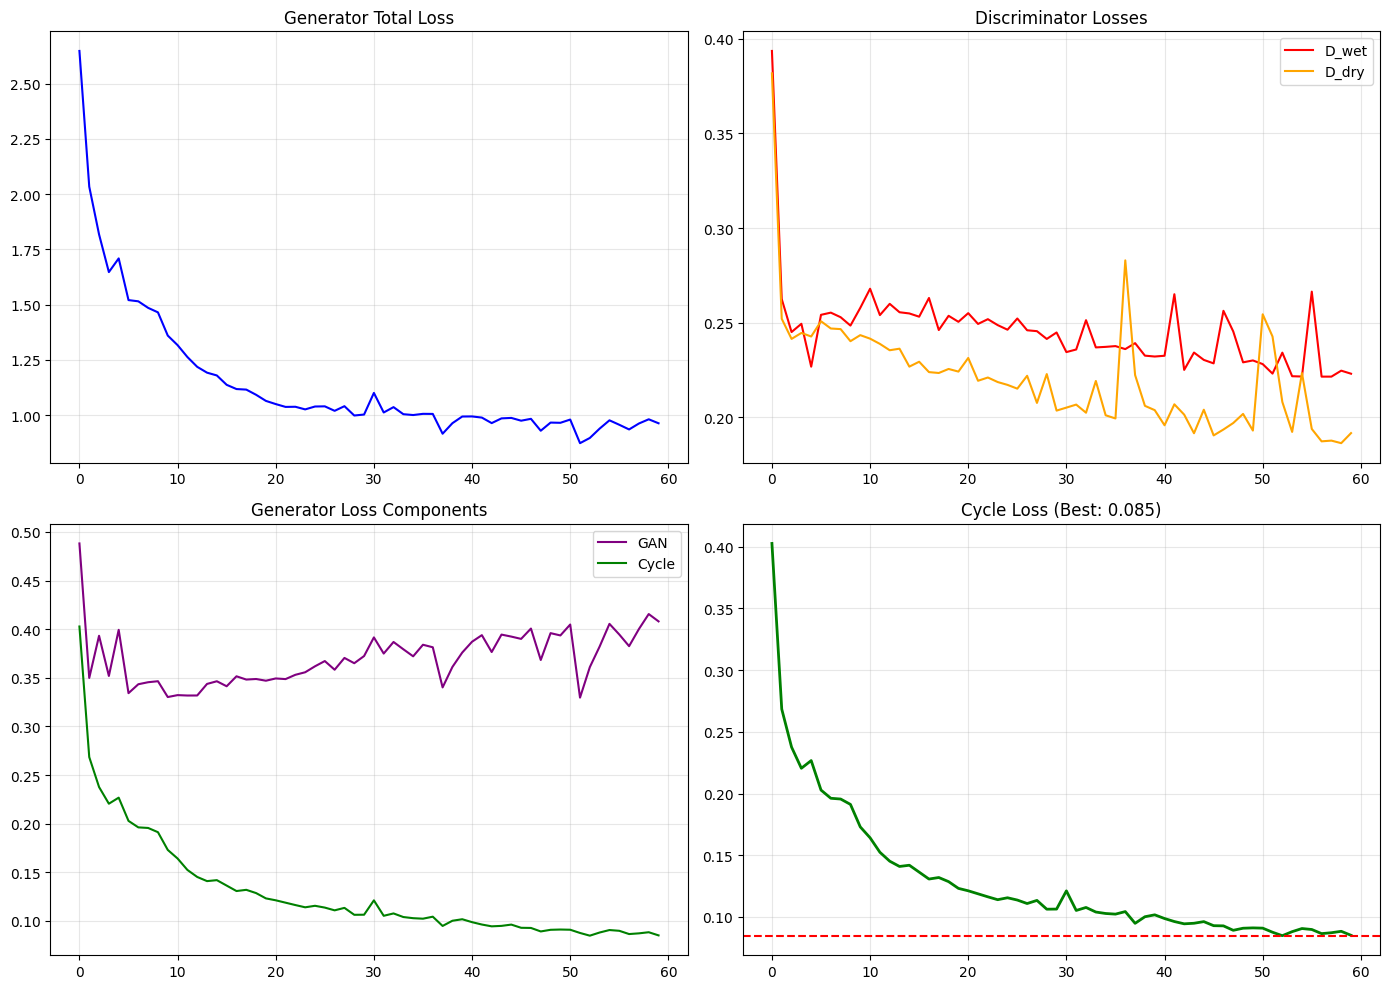

In [ ]:
# ==============================================================
# Cell 11: Plot Training Losses
# ==============================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(training_losses["G"], color="blue")
axes[0, 0].set_title("Generator Total Loss")
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(training_losses["D_wet"], label="D_wet", color="red")
axes[0, 1].plot(training_losses["D_dry"], label="D_dry", color="orange")
axes[0, 1].set_title("Discriminator Losses")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(training_losses["G_GAN"], label="GAN", color="purple")
axes[1, 0].plot(training_losses["G_cycle"], label="Cycle", color="green")
axes[1, 0].set_title("Generator Loss Components")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(training_losses["G_cycle"], color="green", linewidth=2)
axes[1, 1].axhline(y=best_loss_cycle, color="red", linestyle="--")
axes[1, 1].set_title(f"Cycle Loss (Best: {best_loss_cycle:.3f})")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(TEMP_OUTPUT_DIR, "training_losses.png"), dpi=150)
plt.show()

📦 Loading best checkpoint...


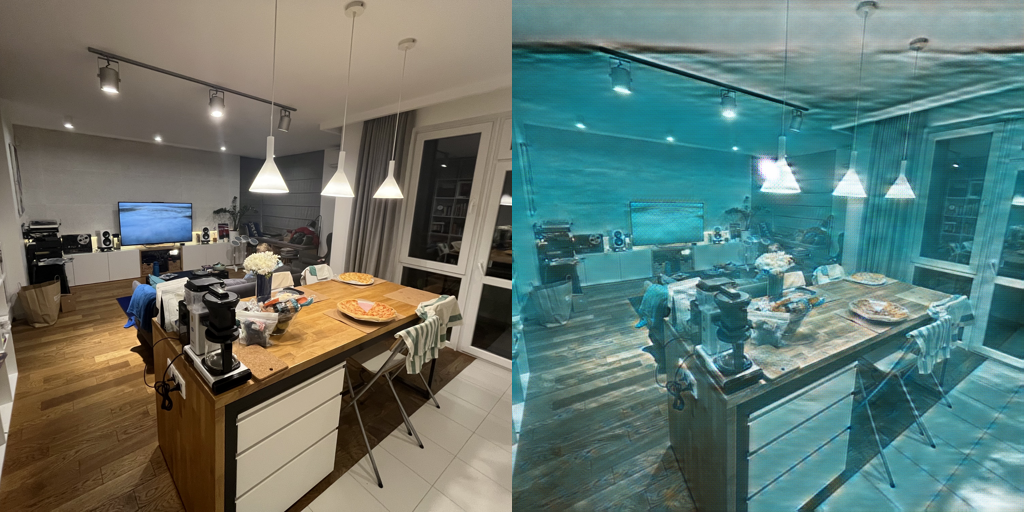

✅ Reference preview generated (dry | wet)


In [ ]:
# ==============================================================
# Cell 12: Generate Final Preview from Reference Image
# ==============================================================

from IPython.display import display

print("📦 Loading best checkpoint...")
best_ckpt_dir = os.path.join(OUTPUT_BASE_DIR, "checkpoint_best")
G_dry2wet.load_state_dict(torch.load(os.path.join(best_ckpt_dir, "G_dry2wet.pth")))
G_dry2wet.eval()

if reference_local and os.path.exists(reference_local):
    transform = transforms.Compose([
        transforms.Resize(512, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    dry_img = Image.open(reference_local).convert("RGB")
    dry_tensor = transform(dry_img).unsqueeze(0).to(device)

    with torch.no_grad():
        fake_wet = G_dry2wet(dry_tensor)

    def denorm(t): return (t + 1) / 2
    dry_pil = transforms.ToPILImage()(denorm(dry_tensor.squeeze(0).cpu()))
    wet_pil = transforms.ToPILImage()(denorm(fake_wet.squeeze(0).cpu()))

    w, h = dry_pil.size
    comparison = Image.new("RGB", (w * 2, h))
    comparison.paste(dry_pil, (0, 0))
    comparison.paste(wet_pil, (w, 0))

    display(comparison)
    print("✅ Reference preview generated (dry | wet)")

In [ ]:
# ==============================================================
# Download Checkpoint xx to Google Drive
# ==============================================================

#mport shutil
import os

checkpoint_dir = os.path.join(TEMP_OUTPUT_DIR, "checkpoint_epoch_048")
drive_output_dir = os.path.join(OUTPUT_BASE_DIR, "checkpoint_epoch_048")

if os.path.exists(checkpoint_dir):
    print(f"📦 Copying checkpoint epoch 76 to Google Drive...")

    # Remove existing if present
    if os.path.exists(drive_output_dir):
        shutil.rmtree(drive_output_dir)

    # Copy to Drive
    shutil.copytree(checkpoint_dir, drive_output_dir)

    print(f"✅ Checkpoint 48 saved to: {drive_output_dir}")
    print(f"   Files: G_dry2wet.pth, G_wet2dry.pth, D_wet.pth, D_dry.pth, training_state.json")

    # Clean up trash
    # cleanup_gdrive_trash()
else:
    print(f"❌ Checkpoint epoch 048 not found at {checkpoint_dir}")

📦 Copying checkpoint epoch 76 to Google Drive...
✅ Checkpoint 48 saved to: /content/drive/MyDrive/FishCropsYOLO/UnderWater SD LoRA 1.5/CycleGAN_ImageSpace_Output/checkpoint_epoch_048
   Files: G_dry2wet.pth, G_wet2dry.pth, D_wet.pth, D_dry.pth, training_state.json
